# U Net Example

First, import the necessary modules

In [ ]:
import torch.nn as nn
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt


Then, check if your code runs on GPU, if not, adjust the settings accordingly.

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mount the google drive so you can access the data.

In [ ]:
from google.colab import drive
# This will prompt for authorization.

drive.mount('/content/drive/')
!ls '/content/drive/'

## Loading the Data

- define a custom dataset
- load the image and mask data according to how it is saved on your drive
- make sure that masks and images are aligned

### Task: write the Dataset

In [ ]:
class CellSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, max_samples=None):
#....

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
#...

        return image, mask

Initialize dataloader and dataset.

In [ ]:
image_folder = '/content/drive/MyDrive/Python Tutorial/crc1328-pythontutorial/data/UNetData/train/image'
mask_folder = '/content/drive/MyDrive/Python Tutorial/crc1328-pythontutorial/data/UNetData/train/mask'


# data transforms -> data augmentation could happen here
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

max_samples = 20

dataset = CellSegmentationDataset(image_folder, mask_folder, transform=data_transform, max_samples=max_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


## Define the U Net

- consists of a series of convolutional layers, followed by max pooling for downsampling in the contraction phase
- expansion phase uses transposed convolutions to upsample the feature maps
- skip connections from the contraction phase are concatenated with the upsampled outputs in the expansion phase

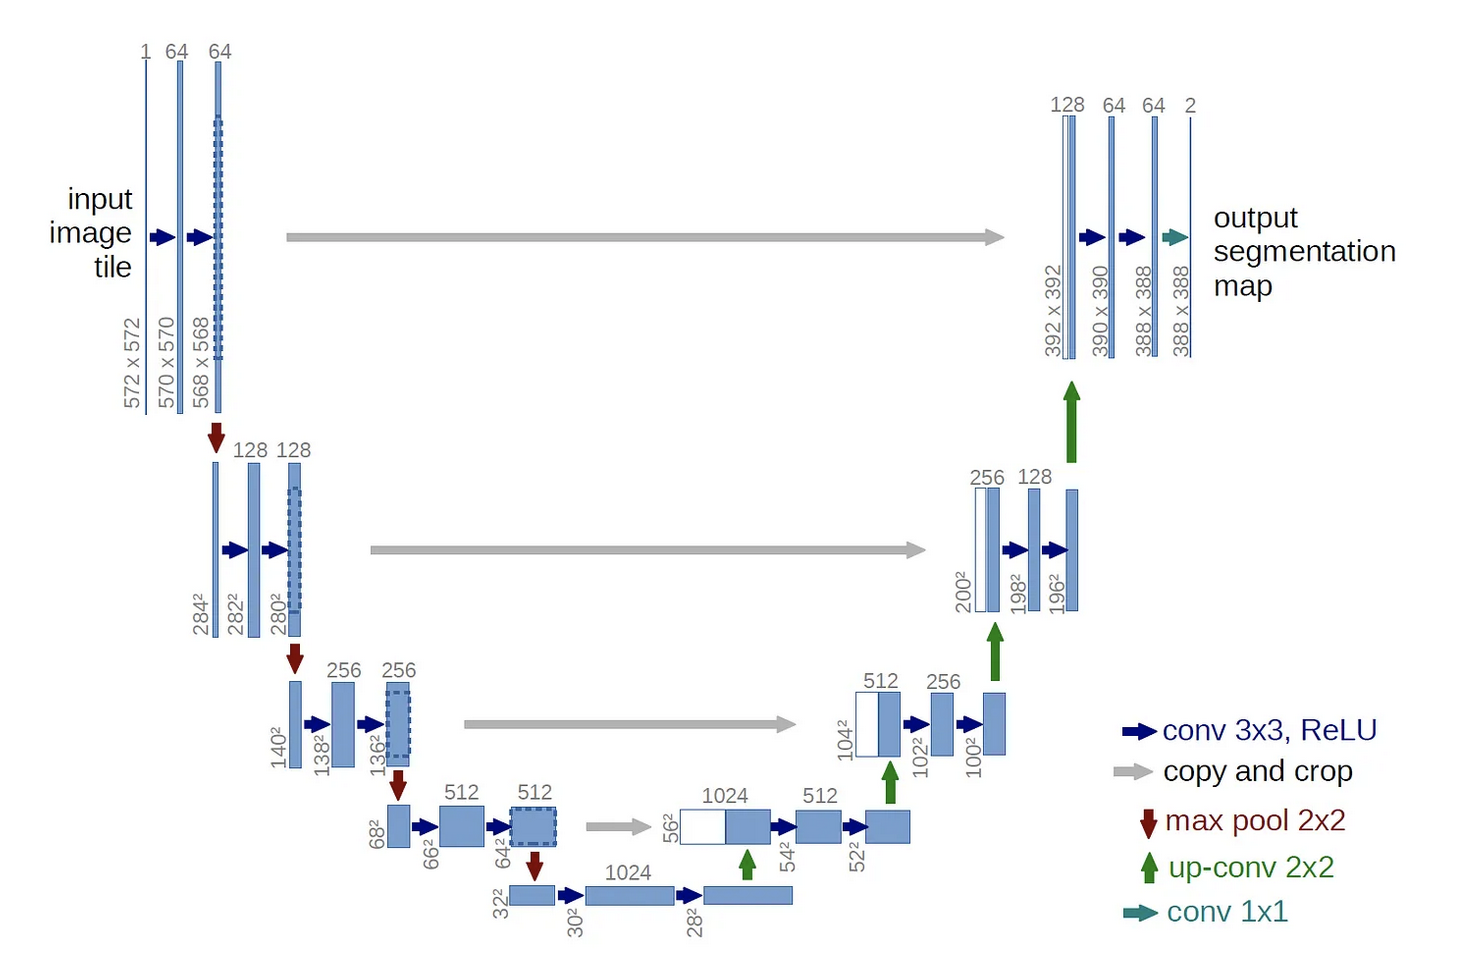

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expanding path
        self.up3 = self.up_block(256, 128)
        self.up2 = self.up_block(256, 64)

        self.out = nn.Conv2d(128, out_channels, kernel_size=1)


    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))

        up3 = self.up3(enc3)
        merge3 = torch.cat([up3, enc2], dim=1)

        up2 = self.up2(merge3)
        merge2 = torch.cat([up2, enc1], dim=1)

        out = self.out(merge2)
        return out


## Start Training

### Task: keep track of average loss over training and plot at the end

In [ ]:
# Initialize the U-Net model, optimizer, and loss function
model = UNet(in_channels=1, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Use Binary Cross Entropy with Logits for binary segmentation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    for images, masks in dataloader:
        optimizer.zero_grad()

        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")


## Test the model using test data

### Task: create test dataset and dataloader

In [ ]:
test_image_folder = '/content/drive/MyDrive/Python Tutorial/crc1328-pythontutorial/data/UNetData/test/image'
test_mask_folder = '/content/drive/MyDrive/Python Tutorial/crc1328-pythontutorial/data/UNetData/test/mask'

# test_dataset = ...
# test_dataloader = ...


In [ ]:
model.eval()  # Set the model to evaluation mode

all_predictions = []
all_masks = []

with torch.no_grad():  # No gradient computation during evaluation
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid to get pixel-wise probabilities
        predictions = (predictions > 0.5).float()  # Binarize predictions

        all_predictions.append(predictions.cpu().numpy())
        all_masks.append(masks.cpu().numpy())


## Evaluate the model

### Task: calculate the dice coefficient

In [ ]:
def dice_coefficient(y_true, y_pred):
    #...

# average_dice = ...
print(f"Average Dice Coefficient: {average_dice:.4f}")


### Task: calculate confusion matrix

In [ ]:
# individual TP/TN/FP/FN values
def confusion_matrix_values(y_true, y_pred):
    # TP = ...
    # TN = ...
    # FP = ...
    # FN = ...
    return TP, TN, FP, FN

# Total values
# TP_total, TN_total, FP_total, FN_total = ...

conf_matrix = np.array([[TP_total, FP_total], [FN_total, TN_total]])
print(conf_matrix)


### Task: calculate accuracy

In [ ]:
# accuracy = ...
print(f"Accuracy: {accuracy:.4f}")


### Task: visualize some predictions

Plot a small number of samples (for example 5) side by side, i.e.

| Original image | True mask | Predicted mask |